In [16]:
import random

import numpy as np
from scipy.optimize import linprog
from scipy.linalg import lstsq
from matplotlib import pyplot as plt

from itertools import permutations

from tqdm import trange

The matrix $A_I$ is initialized with $l \times l$ identity matrix and then we add $(\beta -1) \times l$ random columns.

In [17]:
def place_at_bin(arr, N):
    max_choice = N - arr.sum()
    i = random.randint(0, max_choice)
    index = random.choice(np.where(arr == 0)[0])
    arr[index] = i


def generate_random_cols(N, matrix_size):
    A = np.zeros(matrix_size)
    i = 0
    while i < matrix_size[1]:
        while A[:, i].sum() != N:
            place_at_bin(A[:, i], N)
        # check for any repetitions
        for j in range(i):
            if np.all(A[:, j] == A[:, i]):
                A[:, i] = 0
                i -= 1
        i += 1
    return A / N

In [18]:
def initialize_AI(N, grid_size, beta=5):
    A = np.eye(grid_size)
    random_cols = generate_random_cols(N, (grid_size, beta - 1))
    return np.hstack((A, random_cols))


The cost $c = \sum_{1 \le i < j \le N} w(a_i, a_j)$ has a faster way to compute
$$ c_{\lambda} = \frac{N^2}{2} \lambda^T C \lambda - \frac{N}{2} diag(C)^T \lambda. $$

See
1. Gero Friesecke and Daniela Vögler. Breaking the Curse of Dimension in Multi-Marginal
Kantorovich Optimal Transport on Finite State Spaces. SIAM J. Math. Anal., 50(4):39964019, 2018.
2. Gero Friesecke, Andreas S. Schulz and Daniela Vögler. Genetic column generation: Fast computation of high-dimensional multi-marginal optimal transport problems.

In [19]:
def solve_rmp(AI, cI, marginal):
    result = linprog(cI, A_eq=AI, b_eq=marginal, bounds=(0, None))
    return result.x, result.fun


def solve_dual(AI, cI, marginal):
    c_dual = -marginal  # because linprog does minimization
    result = linprog(c_dual, A_ub=AI.T, b_ub=cI,
                     bounds=[(None, 0) for _ in range(AI.shape[0])],
                     method='highs')
    return result.x


def mutate_parent(parent, grid_size):
    child = parent.copy()
    change_index = random.choice(np.where(parent > 0)[0])
    direction = random.choice([-1, 1])
    destination = max(min(grid_size-1, change_index + direction), 0)
    child[destination] += parent[change_index]
    child[change_index] -= parent[change_index]
    child /= child.sum()
    return child


def compute_cost(lambd, N, cost_matrix: np.ndarray):
    return (N**2/2 * lambd.T @ cost_matrix @ lambd -
            N/2 * cost_matrix.diagonal().T @ lambd)

In [20]:
def genetic_column_generation(
        N,
        l,
        beta,
        pair_potential,
        coordinates_of_sites,
        marginal,
        maxiter,
        maxsamples
):
    a, b = coordinates_of_sites
    x = y = np.linspace(a, b, l)
    X, Y = np.meshgrid(x, y, indexing='ij')
    cost_matrix = pair_potential(X, Y)

    # AI = np.eye(l)
    # AI = np.random.randn(l, l)
    # AI /= AI.sum(axis=0)
    AI = initialize_AI(N, l)
    print('Initialized A_I')

    cI = np.empty(AI.shape[1])
    for j in range(AI.shape[1]):
        cI[j] = compute_cost(AI[:, j], N, cost_matrix)
    samples = 0
    iter = 0
    gain = -1

    cost_history = np.empty((maxiter, 1))
    dual_value_history = np.empty((maxiter, l))

    with trange(maxiter) as t:
        for i in t:
            alpha_I, cost = solve_rmp(AI, cI, marginal)
            cost_history[i] = cost
            y_star = solve_dual(AI, cI, marginal)
            dual_value_history[i, :] = y_star

            while gain <= 0 and samples <= maxsamples:
                # Select a random active column of AI
                parent_index = random.choice(np.where(alpha_I > 0)[0])
                parent = AI[:, parent_index]
                child = mutate_parent(parent, l)
                c_child = compute_cost(child, N, cost_matrix)

                # Calculate gain from adding the child column
                gain = np.dot(child.T, y_star) - c_child

                samples += 1

            # Update AI and cI with the new child column if there's a positive gain
            if gain > 0:
                AI = np.hstack((AI, child[:, np.newaxis]))
                # cI = np.hstack((cI, c_child))
                cI = np.append(cI, c_child)
                if AI.shape[1] > beta * l:
                    # Clear the oldest inactive columns
                    inactive_indices = np.where(alpha_I == 0)[0]
                    AI = np.delete(AI, inactive_indices[:l], axis=1)
                    cI = np.delete(cI, inactive_indices[:l])

            iter += 1

            t.set_postfix(samples=samples, cost=cost)

    # Return the final set of columns and configuration
    alpha_I, cost = solve_rmp(AI, cI, marginal)
    cost_history[i] = cost
    y_star = solve_dual(AI, cI, marginal)
    dual_value_history[i, :] = y_star
    return AI, alpha_I, cost_history, dual_value_history


We set the marginal $\lambda^*$ as

$$ \lambda^* (\{ a_i \}) = c_0 \cdot \left(0.2 + \sin^2 \left(\pi \frac{i}{l+1}\right)\right) $$

where the constant $c_0$ is set such that $\sum \lambda^* (\{a_i\}) = 1$.

And we use the regularized Coulomb interaction
$$ w(a_i, a_j) = \frac{1}{\sqrt{\varepsilon^2 + |a_i - a_j|^2}}. $$

In [28]:
N = 2  # Number of marginals
l = 40  # Number of sites
beta = 5  # Hyperparameter for controlling the maximum columns
maxiter = 500  # Maximum number of iterations
# maxsamples = 1000  # Maximum number of samples for mutations

grid_points = np.arange(1, l+1)

marginal = 0.2 + np.power(np.sin(np.pi * grid_points / (l+1)), 2)
marginal /= marginal.sum()


def pair_potential(x, y, eps=0.1):
    "Use regulatized Coulomb interaction"
    return 1 / np.sqrt(eps**2 + np.power(x - y, 2))

In [29]:
print("1-DIMENSIONAL SETTING.")
print(f"Number of marginals {N=}")
print(f"Number of grid points {l=}")
print(f"Hyperparameter for controlling the maximum columns {beta=}")
print(f"Maximum number of iterations {maxiter=}")

1-DIMENSIONAL SETTING.
Number of marginals N=2
Number of grid points l=40
Hyperparameter for controlling the maximum columns beta=5
Maximum number of iterations maxiter=500


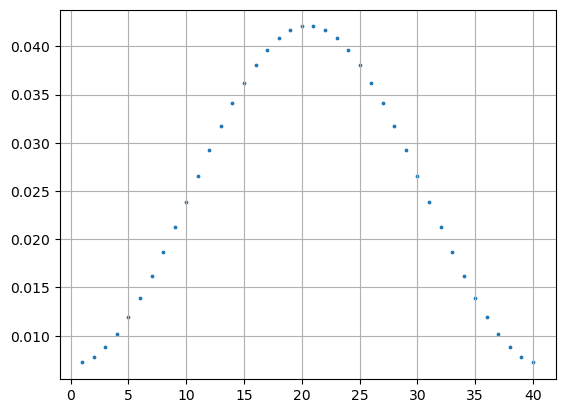

In [30]:
plt.scatter(grid_points, marginal, s=3)
plt.grid()

In [31]:
ai, alpha, cost_history, dual_value_history = genetic_column_generation(
    N, l, beta, pair_potential, (0, 1), marginal, maxiter, 100000)

Initialized A_I


100%|██████████| 500/500 [00:14<00:00, 35.20it/s, cost=10, samples=1e+5] 


gamma.shape=(40,)


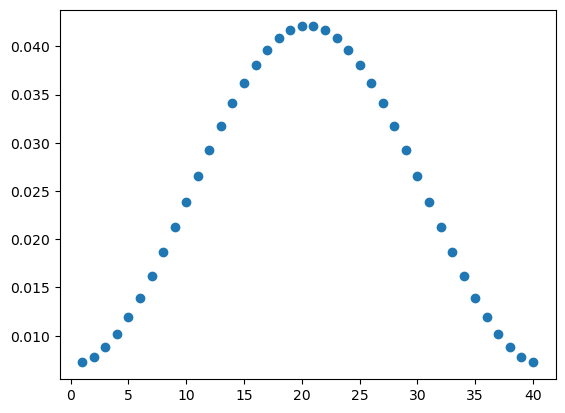

In [32]:
gamma = ai @ alpha
print(f"{gamma.shape=}")

plt.scatter(grid_points, gamma)
plt.show()

In [33]:
def generate_tensor(N, l, lambd):
    indices = []
    for i in range(l):
        indices.extend([i] * lambd[i])

    def delta(l, i):
        return np.fromfunction(lambda j: i == j, (l,)).astype(np.int32)

    def tensor_product(arrays):
        result = arrays[0]
        for array in arrays[1:]:
            result = np.outer(result, array)
            result = result.reshape(-1)
        return result.reshape([len(arrays[0])] * len(arrays))

    # Prepare tensor list
    tensor = np.zeros([l] * N)

    for perm in permutations(indices):
        deltas = [delta(l, i) for i in perm]
        tensor += tensor_product(deltas)

    return tensor


In [34]:
density = np.zeros([l] * N)
for i, col in enumerate(ai):
    density += alpha[i] * \
        generate_tensor(N, l, (N * col).astype(np.int32))

print(density.shape)
# plt.imshow(density[20])
# plt.show()
samples <= maxsamples
nrows = 5
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))

for i in range(20):
    print(i)
    ax = axes[i // nrows, i % ncols]
    ax.imshow(density[i], cmap='viridis')
    ax.set_title(f'Slice {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()


(40, 40)


NameError: name 'samples' is not defined